In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import zipfile
import shutil

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
# Definisikan path kaggle json
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

In [ ]:
# Ekstrak file dataset dan hapus file zip dataset agar tidak memakan banyak tempat.
import zipfile

local_zip = 'breast-histopathology-images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/BreastCancer') #mengeksrak file zip ke direktory yang sudah ditentukan
zip_ref.close()

In [ ]:
!rm /content/breast-histopathology-images.zip
!rm -r /content/BreastCancer/IDC_regular_ps50_idx5

In [ ]:
base_dataset = "/content/BreastCancer"
cancer_dir = os.listdir(base_dataset)

In [ ]:
#memastikan gambar png
for class_item in cancer_dir:
  cur_dir = base_dataset+"/"+class_item
  for dir in os.listdir(cur_dir):
    items_dir = cur_dir+"/"+dir
    for item in os.listdir(items_dir):
      if not item.endswith(".png"):
          os.remove(os.path.join(cur_dir, item))

In [ ]:
BreastCancerImage = 'BreastCancerImage'
image_non_idc_dir = '/content/BreastCancerImage/non_idc'
image_idc_dir = '/content/BreastCancerImage/idc'

os.mkdir (BreastCancerImage)
os.mkdir (image_non_idc_dir)
os.mkdir (image_idc_dir)

In [ ]:
#jadikan 1
for patient in cancer_dir:   
    path_0 = base_dataset +'/'+str(patient) + '/0'
    path_1 = base_dataset +'/'+str(patient) + '/1'
    file_list_0 = os.listdir(path_0)   
    file_list_1 = os.listdir(path_1)
    for fname in file_list_0:
            src = os.path.join(path_0, fname)
            dst = os.path.join(image_non_idc_dir, fname)
            shutil.copyfile(src, dst)
    for fname in file_list_1: 
        src = os.path.join(path_1, fname)
        dst = os.path.join(image_idc_dir, fname)
        shutil.copyfile(src, dst)

In [ ]:
print (len(os.listdir('/content/BreastCancerImage/idc')))
print (len(os.listdir('/content/BreastCancerImage/non_idc')))

78786
198738


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

splitfolders.ratio("/content/BreastCancerImage", output='SplitWithRatio', seed=42, ratio=(0.5, 0.5),group_prefix=None)

In [ ]:
!rm -r /content/BreastCancer
!rm -r /content/BreastCancerImage

In [ ]:
train_ratio_idc_dir = '/content/SplitWithRatio/train/idc'
train_ratio_non_idc_dir = '/content/SplitWithRatio/train/non_idc'
val_ratio_idc_dir = '/content/SplitWithRatio/val/idc'
val_ratio_non_idc_dir = '/content/SplitWithRatio/val/non_idc'

train_ratio_idc = os.listdir(train_ratio_idc_dir)
train_ratio_non_idc = os.listdir(train_ratio_non_idc_dir)
val_ratio_idc = os.listdir(val_ratio_idc_dir)
val_ratio_non_idc = os.listdir(val_ratio_non_idc_dir)

In [ ]:
nrows = 4
ncols = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index +=4
next_idc_ratio = [os.path.join(train_ratio_idc_dir, fname) 
                for fname in os.listdir(train_ratio_idc_dir)[pic_index-4:pic_index]]
next_non_idc_ratio = [os.path.join(train_ratio_non_idc_dir, fname) 
                for fname in os.listdir(train_ratio_non_idc_dir)[pic_index-4:pic_index]]


for i, img_path in enumerate(next_idc_ratio+next_non_idc_ratio):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.title(img_path.split(os.path.sep)[-2])
  plt.imshow(img)

plt.show()

In [ ]:
splitfolders.ratio("/content/SplitWithRatio/train", output='Datasets', seed=42, ratio=(.7, .2, .1),group_prefix=None)

In [ ]:
print ("Test idc :" ,len(os.listdir('/content/Datasets/test/idc')))
print ("Test non idc :" ,len(os.listdir('/content/Datasets/test/non_idc')))
print ("train idc :" ,len(os.listdir('/content/Datasets/train/idc')))
print ("train non idc :" ,len(os.listdir('/content/Datasets/train/non_idc')))
print ("Val idc :" ,len(os.listdir('/content/Datasets/val/idc')))
print ("Val non idc :" ,len(os.listdir('/content/Datasets/val/non_idc')))

In [ ]:
!rm -r /content/SplitWithRatio

In [ ]:
data_train = "/content/Datasets/train"
data_val = "/content/Datasets/val"
data_test = "/content/Datasets/test"

In [ ]:
#normalisasi menggunakan ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0/255.0)


In [ ]:
input_shape = (60, 60)

train_generator = datagen.flow_from_directory(data_train,
                                              target_size=input_shape,
                                              class_mode='categorical',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= False)

validation_generator = datagen.flow_from_directory(data_val,
                                              target_size=input_shape,
                                              class_mode='categorical',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= False)

test_generator = datagen.flow_from_directory(data_test,
                                              target_size=input_shape,
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= False)

In [ ]:
best_model1 = 'best_model1.h5'
checkpoint_callback = ModelCheckpoint(best_model1,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.000003, verbose=1)
callbacks_list = [checkpoint_callback, reduce_callback]

In [ ]:
model1 = Sequential()

model1.add(InputLayer(input_shape=[50,50,3]))
model1.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=2, padding='same'))
model1.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=2, padding='same'))
model1.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=2, padding='same'))
model1.add(Dropout(0.25))
model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dropout(0.05))
model1.add(Dense(2, activation='sigmoid'))

model1.summary()

In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.001, decay=0.001/20),
              metrics=['accuracy'])

In [ ]:
H1 = model1.fit_generator(train_generator,
                             epochs = 20,
                             validation_data = validation_generator, callbacks= callbacks_list)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(5)
fig.set_figwidth(20)

ax1.plot(np.arange(0, 20), H1.history["loss"], label="loss_model_H1")
ax1.plot(np.arange(0, 20), H1.history["val_loss"], label="val_loss_model_H1")
ax1.set_title("Grafik loss dan accuracy")
#ax1.set_xlabel("Epoch #")
ax1.set_ylabel("Loss")
ax1.legend()


ax2.plot(np.arange(0, 20), H1.history["accuracy"], label="acc_model_H1")
ax2.plot(np.arange(0, 20), H1.history["val_accuracy"], label="val_acc_model_H1")
#ax2.set_title("Accuracy Result Plot")
ax2.set_xlabel("Epoch #")
ax2.set_ylabel("Acc")
ax2.legend()

In [ ]:
best_model2 = 'best_model2.h5'
checkpoint_callback = ModelCheckpoint(best_model2,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.000003, verbose=1)
callbacks_list = [checkpoint_callback, reduce_callback]

In [ ]:
model2 = Sequential()

model2.add(InputLayer(input_shape=[50,50,3]))
model2.add(Conv2D(32, kernel_size=3, strides=1,padding='same',activation='relu'))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(2, padding='same'))
model2.add(Conv2D(64, kernel_size=3, strides=1,padding='same',activation='relu'))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(2, padding='same'))
model2.add(Conv2D(128, kernel_size=3, strides=1,padding='same',activation='relu'))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(2, padding='same'))
model2.add(GlobalAveragePooling2D())
model1.add(Dropout(0.25))
model2.add(Flatten())

model2.add(Dense(256,activation='relu'))
model2.add(Dense(256,activation='relu'))
model2.add(Dense(512,activation='relu'))
model1.add(Dropout(0.5))
model2.add(Dense(2,activation='softmax'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 60, 60, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 60, 60, 32)       128       
 hNormalization)                                                 
                                                                 
 average_pooling2d_3 (Averag  (None, 30, 30, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
H2 = model2.fit_generator(train_generator,
                             epochs = 20,
                             validation_data = validation_generator, callbacks= callbacks_list)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


3035/3036 [============================>.] - ETA: 0s - loss: 0.3743 - accuracy: 0.8440
Epoch 1: val_accuracy improved from -inf to 0.38035, saving model to best_model.h5
3036/3036 [==============================] - 69s 22ms/step - loss: 0.3742 - accuracy: 0.8440 - val_loss: 1.1237 - val_accuracy: 0.3803 - lr: 0.0010
Epoch 2/20
3034/3036 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.9166
Epoch 2: val_accuracy improved from 0.38035 to 0.67875, saving model to best_model.h5
3036/3036 [==============================] - 68s 22ms/step - loss: 0.2227 - accuracy: 0.9167 - val_loss: 0.8972 - val_accuracy: 0.6788 - lr: 0.0010
Epoch 3/20
3034/3036 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9280
Epoch 3: val_accuracy improved from 0.67875 to 0.75042, saving model to best_model.h5
3036/3036 [==============================] - 67s 22ms/step - loss: 0.1962 - accuracy: 0.9281 - val_loss: 0.7775 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 4/20
3033/30

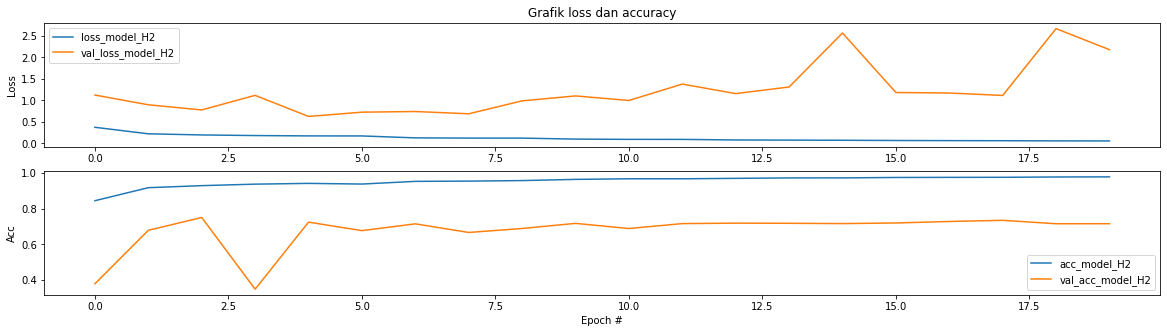

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(5)
fig.set_figwidth(20)

ax1.plot(np.arange(0, 20), H2.history["loss"], label="loss_model_H2")
ax1.plot(np.arange(0, 20), H2.history["val_loss"], label="val_loss_model_H2")
ax1.set_title("Grafik loss dan accuracy")
#ax1.set_xlabel("Epoch #")
ax1.set_ylabel("Loss")
ax1.legend()


ax2.plot(np.arange(0, 20), H2.history["accuracy"], label="acc_model_H2")
ax2.plot(np.arange(0, 20), H2.history["val_accuracy"], label="val_acc_model_H2")
#ax2.set_title("Accuracy Result Plot")
ax2.set_xlabel("Epoch #")
ax2.set_ylabel("Acc")
ax2.legend()

In [ ]:
from sklearn.metrics import classification_report

print('================== model 1 ==================')
ypred = model1.predict(test_generator)
predictions = np.argmax(ypred, axis = 1)
print(classification_report(test_generator.classes,predictions))

print('================== model 2 ==================')
ypred = model2.predict(test_generator)
predictions = np.argmax(ypred, axis = 1)
print(classification_report(test_generator.classes,predictions))